# Variational Autoencoder on MNIST

Source: [https://keras.io/examples/generative/vae/](https://keras.io/examples/generative/vae/)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

strategy = tf.distribute.OneDeviceStrategy('cpu:0')

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [37]:
# Lint as: python3
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Keras-based attention layer."""
# pylint: disable=g-classes-have-attributes
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import string

import numpy as np

from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers import advanced_activations
from tensorflow.python.keras.layers import core
from tensorflow.python.keras.layers import einsum_dense
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import special_math_ops
from tensorflow.python.util.tf_export import keras_export


_CHR_IDX = string.ascii_lowercase


def _build_attention_equation(rank, attn_axes):
  """Builds einsum equations for the attention computation.

  Query, key, value inputs after projection are expected to have the shape as:
  (bs, <non-attention dims>, <attention dims>, num_heads, channels).
  bs and <non-attention dims> are treated as <batch dims>.
  The attention operations can be generalized:
  (1) Query-key dot product:
  (<batch dims>, <query attention dims>, num_heads, channels), (<batch dims>,
  <key attention dims>, num_heads, channels) -> (<batch dims>,
  num_heads, <query attention dims>, <key attention dims>)
  (2) Combination:
  (<batch dims>, num_heads, <query attention dims>, <key attention dims>),
  (<batch dims>, <value attention dims>, num_heads, channels) -> (<batch dims>,
  <query attention dims>, num_heads, channels)

  Args:
    rank: the rank of query, key, value tensors.
    attn_axes: a list/tuple of axes, [-1, rank), that will do attention.

  Returns:
    Einsum equations.
  """
  target_notation = _CHR_IDX[:rank]
  # `batch_dims` includes the head dim.
  batch_dims = tuple(np.delete(range(rank), attn_axes + (rank - 1,)))
  letter_offset = rank
  source_notation = ""
    for i in range(rank):
        if i in batch_dims or i == rank - 1:
      source_notation += target_notation[i]
    else:
      source_notation += _CHR_IDX[letter_offset]
      letter_offset += 1

  product_notation = "".join([target_notation[i] for i in batch_dims] +
                             [target_notation[i] for i in attn_axes] +
                             [source_notation[i] for i in attn_axes])
  dot_product_equation = "%s,%s->%s" % (source_notation, target_notation,
                                        product_notation)
  attn_scores_rank = len(product_notation)
  combine_equation = "%s,%s->%s" % (product_notation, source_notation,
                                    target_notation)
    return dot_product_equation, combine_equation, attn_scores_rank


def _build_proj_equation(free_dims, bound_dims, output_dims):
  """Builds an einsum equation for projections inside multi-head attention."""
  input_str = ""
  kernel_str = ""
  output_str = ""
  bias_axes = ""
  letter_offset = 0
    for i in range(free_dims):
        char = _CHR_IDX[i + letter_offset]
        input_str += char
        output_str += char

  letter_offset += free_dims
  for i in range(bound_dims):
        char = _CHR_IDX[i + letter_offset]
        input_str += char
        kernel_str += char

  letter_offset += bound_dims
  for i in range(output_dims):
    char = _CHR_IDX[i + letter_offset]
    kernel_str += char
    output_str += char
    bias_axes += char
  equation = "%s,%s->%s" % (input_str, kernel_str, output_str)

  return equation, bias_axes, len(output_str)


def _get_output_shape(output_rank, known_last_dims):
    return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)


@keras_export("keras.layers.MultiHeadAttention")
class MultiHeadAttentionTranspose(Layer):
  """MultiHeadAttention layer.

  This is an implementation of multi-headed attention based on "Attention
  is all you Need". If `query`, `key,` `value` are the same, then
  this is self-attention. Each timestep in `query` attends to the
  corresponding sequence in `key`, and returns a fixed-width vector.

  This layer first projects `query`, `key` and `value`. These are
  (effectively) a list of tensors of length `num_attention_heads`, where the
  corresponding shapes are [batch_size, <query dimensions>, key_dim],
  [batch_size, <key/value dimensions>, key_dim],
  [batch_size, <key/value dimensions>, value_dim].

  Then, the query and key tensors are dot-producted and scaled. These are
  softmaxed to obtain attention probabilities. The value tensors are then
  interpolated by these probabilities, then concatenated back to a single
  tensor.

  Finally, the result tensor with the last dimension as value_dim can take an
  linear projection and return.

  Examples:

  Performs 1D cross-attention over two sequence inputs with an attention mask.
  Returns the additional attention weights over heads.

  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2)
  >>> target = tf.keras.Input(shape=[8, 16])
  >>> source = tf.keras.Input(shape=[4, 16])
  >>> output_tensor, weights = layer(target, source,
  ...                                return_attention_scores=True)
  >>> print(output_tensor.shape)
  (None, 8, 16)
  >>> print(weights.shape)
  (None, 2, 8, 4)

  Performs 2D self-attention over a 5D input tensor on axes 2 and 3.

  >>> layer = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(2, 3))
  >>> input_tensor = tf.keras.Input(shape=[5, 3, 4, 16])
  >>> output_tensor = layer(input_tensor, input_tensor)
  >>> print(output_tensor.shape)
  (None, 5, 3, 4, 16)

  Arguments:
    num_heads: Number of attention heads.
    key_dim: Size of each attention head for query and key.
    value_dim:  Size of each attention head for value.
    dropout: Dropout probability.
    use_bias: Boolean, whether the dense layers use bias vectors/matrices.
    output_shape: The expected shape of an output tensor, besides the batch and
      sequence dims. If not specified, projects back to the key feature dim.
    attention_axes: axes over which the attention is applied. `None` means
      attention over all axes, but batch, heads, and features.
    kernel_initializer: Initializer for dense layer kernels.
    bias_initializer: Initializer for dense layer biases.
    kernel_regularizer: Regularizer for dense layer kernels.
    bias_regularizer: Regularizer for dense layer biases.
    activity_regularizer: Regularizer for dense layer activity.
    kernel_constraint: Constraint for dense layer kernels.
    bias_constraint: Constraint for dense layer kernels.

  Call arguments:
    query: Query `Tensor` of shape `[B, T, dim]`.
    value: Value `Tensor` of shape `[B, S, dim]`.
    key: Optional key `Tensor` of shape `[B, S, dim]`. If not given, will use
      `value` for both `key` and `value`, which is the most common case.
    attention_mask: a boolean mask of shape `[B, T, S]`, that prevents
      attention to certain positions.
    return_attention_scores: A boolean to indicate whether the output should
      be attention output if True, or (attention_output, attention_scores) if
      False. Defaults to False.
    training: Python boolean indicating whether the layer should behave in
      training mode (adding dropout) or in inference mode (no dropout).
      Defaults to either using the training mode of the parent layer/model,
      or False (inference) if there is no parent layer.

  Returns:
    attention_output: The result of the computation, of shape [B, T, E],
      where `T` is for target sequence shapes and `E` is the query input last
      dimension if `output_shape` is `None`. Otherwise, the multi-head outputs
      are project to the shape specified by `output_shape`.
    attention_scores: [Optional] multi-head attention coeffients over
      attention axes.
  """

  def __init__(self,
               num_heads,
               key_dim,
               value_dim=None,
               dropout=0.0,
               use_bias=True,
               output_shape=None,
               attention_axes=None,
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs)
    self._num_heads = num_heads
    self._key_dim = key_dim
    self._value_dim = value_dim if value_dim else key_dim
    self._dropout = dropout
    self._use_bias = use_bias
    self._output_shape = output_shape
    self._kernel_initializer = initializers.get(kernel_initializer)
    self._bias_initializer = initializers.get(bias_initializer)
    self._kernel_regularizer = regularizers.get(kernel_regularizer)
    self._bias_regularizer = regularizers.get(bias_regularizer)
    self._kernel_constraint = constraints.get(kernel_constraint)
    self._bias_constraint = constraints.get(bias_constraint)
    if attention_axes is not None and not isinstance(attention_axes,
                                                     collections.abc.Sized):
      self._attention_axes = (attention_axes,)
    else:
      self._attention_axes = attention_axes
    self._built_from_signature = False

def get_config(self):
    config = {
        "num_heads":
            self._num_heads,
        "key_dim":
            self._key_dim,
        "value_dim":
            self._value_dim,
        "dropout":
            self._dropout,
        "use_bias":
            self._use_bias,
        "output_shape":
            self._output_shape,
        "attention_axes":
            self._attention_axes,
        "kernel_initializer":
            initializers.serialize(self._kernel_initializer),
        "bias_initializer":
            initializers.serialize(self._bias_initializer),
        "kernel_regularizer":
            regularizers.serialize(self._kernel_regularizer),
        "bias_regularizer":
            regularizers.serialize(self._bias_regularizer),
        "activity_regularizer":
            regularizers.serialize(self._activity_regularizer),
        "kernel_constraint":
            constraints.serialize(self._kernel_constraint),
        "bias_constraint":
            constraints.serialize(self._bias_constraint)
    }
    base_config = super(MultiHeadAttention, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

def _build_from_signature(self, query, value, key=None):
    """Builds layers and variables.

    Once the method is called, self._built_from_signature will be set to True.

    Args:
      query: query tensor or TensorShape.
      value: value tensor or TensorShape.
      key: key tensor or TensorShape.
    """
    self._built_from_signature = True
    if hasattr(query, "shape"):
      query_shape = tensor_shape.TensorShape(query.shape)
    else:
      query_shape = query
    if hasattr(value, "shape"):
      value_shape = tensor_shape.TensorShape(value.shape)
    else:
      value_shape = value
    if key is None:
      key_shape = value_shape
    elif hasattr(key, "shape"):
      key_shape = tensor_shape.TensorShape(key.shape)
    else:
      key_shape = key

    common_kwargs = dict(
        kernel_initializer=self._kernel_initializer,
        bias_initializer=self._bias_initializer,
        kernel_regularizer=self._kernel_regularizer,
        bias_regularizer=self._bias_regularizer,
        activity_regularizer=self._activity_regularizer,
        kernel_constraint=self._kernel_constraint,
        bias_constraint=self._bias_constraint)
    # Any setup work performed only once should happen in an `init_scope`
    # to avoid creating symbolic Tensors that will later pollute any eager
    # operations.
    with tf_utils.maybe_init_scope(self):
      free_dims = query_shape.rank - 1
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          free_dims, bound_dims=1, output_dims=2)
      self._query_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="query",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          key_shape.rank - 1, bound_dims=1, output_dims=2)
      self._key_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._key_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="key",
          **common_kwargs)
      einsum_equation, bias_axes, output_rank = _build_proj_equation(
          value_shape.rank - 1, bound_dims=1, output_dims=2)
      self._value_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1,
                                         [self._num_heads, self._value_dim]),
          bias_axes=bias_axes if self._use_bias else None,
          name="value",
          **common_kwargs)

      # Builds the attention computations for multi-head dot product attention.
      # These computations could be wrapped into the keras attention layer once
      # it support mult-head einsum computations.
      self._build_attention(output_rank)
        if self._output_shape:
            if not isinstance(self._output_shape, collections.abc.Sized):
              output_shape = [self._output_shape]
            else:
              output_shape = self._output_shape
        else:
            output_shape = [query_shape[-1]]
              einsum_equation, bias_axes, output_rank = _build_proj_equation(
              free_dims, bound_dims=2, output_dims=len(output_shape))
        self._output_dense = einsum_dense.EinsumDense(
          einsum_equation,
          output_shape=_get_output_shape(output_rank - 1, output_shape),
          bias_axes=bias_axes if self._use_bias else None,
          name="attention_output",
          **common_kwargs)

  def _build_attention(self, rank):
    """Builds multi-head dot-product attention computations.

    This function builds attributes necessary for `_compute_attention` to
    costomize attention computation to replace the default dot-product
    attention.

    Args:
      rank: the rank of query, key, value tensors.
    """
    if self._attention_axes is None:
      self._attention_axes = tuple(range(1, rank - 2))
    else:
      self._attention_axes = tuple(self._attention_axes)
    self._dot_product_equation, self._combine_equation, attn_scores_rank = (
        _build_attention_equation(rank, attn_axes=self._attention_axes))
    norm_axes = tuple(
        range(attn_scores_rank - len(self._attention_axes), attn_scores_rank))
    self._softmax = advanced_activations.Softmax(axis=norm_axes)
    self._dropout_layer = core.Dropout(rate=self._dropout)

  def _masked_softmax(self, attention_scores, attention_mask=None):
    # Normalize the attention scores to probabilities.
    # `attention_scores` = [B, N, T, S]
    if attention_mask is not None:
      # The expand dim happens starting from the `num_heads` dimension,
      # (<batch_dims>, num_heads, <query_attention_dims, key_attention_dims>)
      mask_expansion_axes = [-len(self._attention_axes) * 2 - 1]
      for _ in range(len(attention_scores.shape) - len(attention_mask.shape)):
        attention_mask = array_ops.expand_dims(
            attention_mask, axis=mask_expansion_axes)
    return self._softmax(attention_scores, attention_mask)

  def _compute_attention(self,
                         query,
                         key,
                         value,
                         attention_mask=None,
                         training=None):
    """Applies Dot-product attention with query, key, value tensors.

    This function defines the computation inside `call` with projected
    multi-head Q, K, V inputs. Users can override this function for customized
    attention implementation.

    Args:
      query: Projected query `Tensor` of shape `[B, T, N, key_dim]`.
      key: Projected key `Tensor` of shape `[B, T, N, key_dim]`.
      value: Projected value `Tensor` of shape `[B, T, N, value_dim]`.
      attention_mask: a boolean mask of shape `[B, T, S]`, that prevents
        attention to certain positions.
      training: Python boolean indicating whether the layer should behave in
        training mode (adding dropout) or in inference mode (doing nothing).

    Returns:
      attention_output: Multi-headed outputs of attention computation.
      attention_scores: Multi-headed attention weights.
    """
    # Note: Applying scalar multiply at the smaller end of einsum improves
    # XLA performance, but may introduce slight numeric differences in
    # the Transformer attention head.
    query = math_ops.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))

    # Take the dot product between "query" and "key" to get the raw
    # attention scores.
    attention_scores = special_math_ops.einsum(self._dot_product_equation, key,
                                               query)

    attention_scores = self._masked_softmax(attention_scores, attention_mask)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_scores_dropout = self._dropout_layer(
        attention_scores, training=training)

    # `context_layer` = [B, T, N, H]
    attention_output = special_math_ops.einsum(self._combine_equation,
                                               attention_scores_dropout, value)
    return attention_output, attention_scores

  def call(self,
           query,
           value,
           key=None,
           attention_mask=None,
           return_attention_scores=False,
           training=None):
    if not self._built_from_signature:
      self._build_from_signature(query=query, value=value, key=key)
    if key is None:
      key = value

    #   N = `num_attention_heads`
    #   H = `size_per_head`
    # `query` = [B, T, N ,H]
    query = self._query_dense(query)

    # `key` = [B, S, N, H]
    key = self._key_dense(key)

    # `value` = [B, S, N, H]
    value = self._value_dense(value)

    attention_output, attention_scores = self._compute_attention(
        query, key, value, attention_mask, training)
    attention_output = self._output_dense(attention_output)

    if return_attention_scores:
      return attention_output, attention_scores
    return attention_output


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 76)

In [5]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [20]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2] # x already embedded
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

***EMBEDD DNA***

In [12]:
def dna_embedder(file):
    all_lines = open(file).readlines() #opens fasta files and reads in all lines (sequence + quality scores + sequence identifier)
    list_dna = [all_lines[i+1].strip() for i, line in enumerate(all_lines) if line[0:2] == "@M"]
    
    #preprocess dna making sure all dna has the same length
    list_dna = [dna + ("X" * (252 - len(dna))) for dna in list_dna]
    
    #Strip DNA base pairs and store in string
    final_dna_embed = []
    for dna in list_dna:
        temp_dna = [base.upper() for base in dna]
        final_dna_embed.append(temp_dna) 
        
    #embed dna using one-hot-encoding 
    dna_A = [1, 0, 0, 0]  #A
    dna_C = [0, 1, 0, 0]  #C
    dna_G = [0, 0, 1, 0]  #G
    dna_T = [0, 0, 0, 1]  #T   
    
     
    #Embed dna bases in one-hot-encoding method
    for i, dna_list in enumerate(final_dna_embed): 
        for j, base in enumerate(dna_list):
            if base == "A":
                one_hot_embed = dna_A
            elif base == "C":
                one_hot_embed = dna_C
            elif base == "G":
                one_hot_embed = dna_G
            elif base == "T":
                one_hot_embed = dna_T
            else:
                one_hot_embed = [0,0,0,0]
            
            final_dna_embed[i][j] = one_hot_embed
        
    #Convert final embedding to numpy array
    final_dna_embed = np.array(final_dna_embed)
    
    return final_dna_embed

In [13]:
x_train = dna_embedder("D1-HGG.fastq")

In [14]:
x_train.shape

(63262, 252, 4)

In [16]:
x_train = x_train.reshape(63262, 252, 4, 1)

In [17]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
# x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0
# # x_train = 1.0 - (np.expand_dims(x_train, -1).astype("float32") / 127.5)
# # x_test = 1.0 - (np.expand_dims(x_test, -1).astype("float32") / 127.5)

In [18]:
with strategy.scope():
    data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.Normalization(),
            layers.experimental.preprocessing.Resizing(x_train.shape[1],
                                                       x_train.shape[2]),
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(factor=0.02),
            layers.experimental.preprocessing.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    # Compute the mean and the variance of the training data for normalization.
    data_augmentation.layers[0].adapt(x_train)

In [23]:
latent_dim = 10
embed_dim = 64
num_heads = 8
ff_dim = 128

with strategy.scope():
    encoder_inputs = keras.Input(shape=(252, 4, 1))
    x = data_augmentation(encoder_inputs)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(embed_dim, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Reshape((-1,embed_dim))(x)
    embedding_layer = PositionEmbedding(x.shape[-2],embed_dim)
    x = embedding_layer(x)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    # x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 252, 4, 1)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 252, 4, 1)    3           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 126, 2, 32)   320         data_augmentation[2][0]          
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 63, 1, 64)    18496       conv2d_4[0][0]                   
____________________________________________________________________________________________

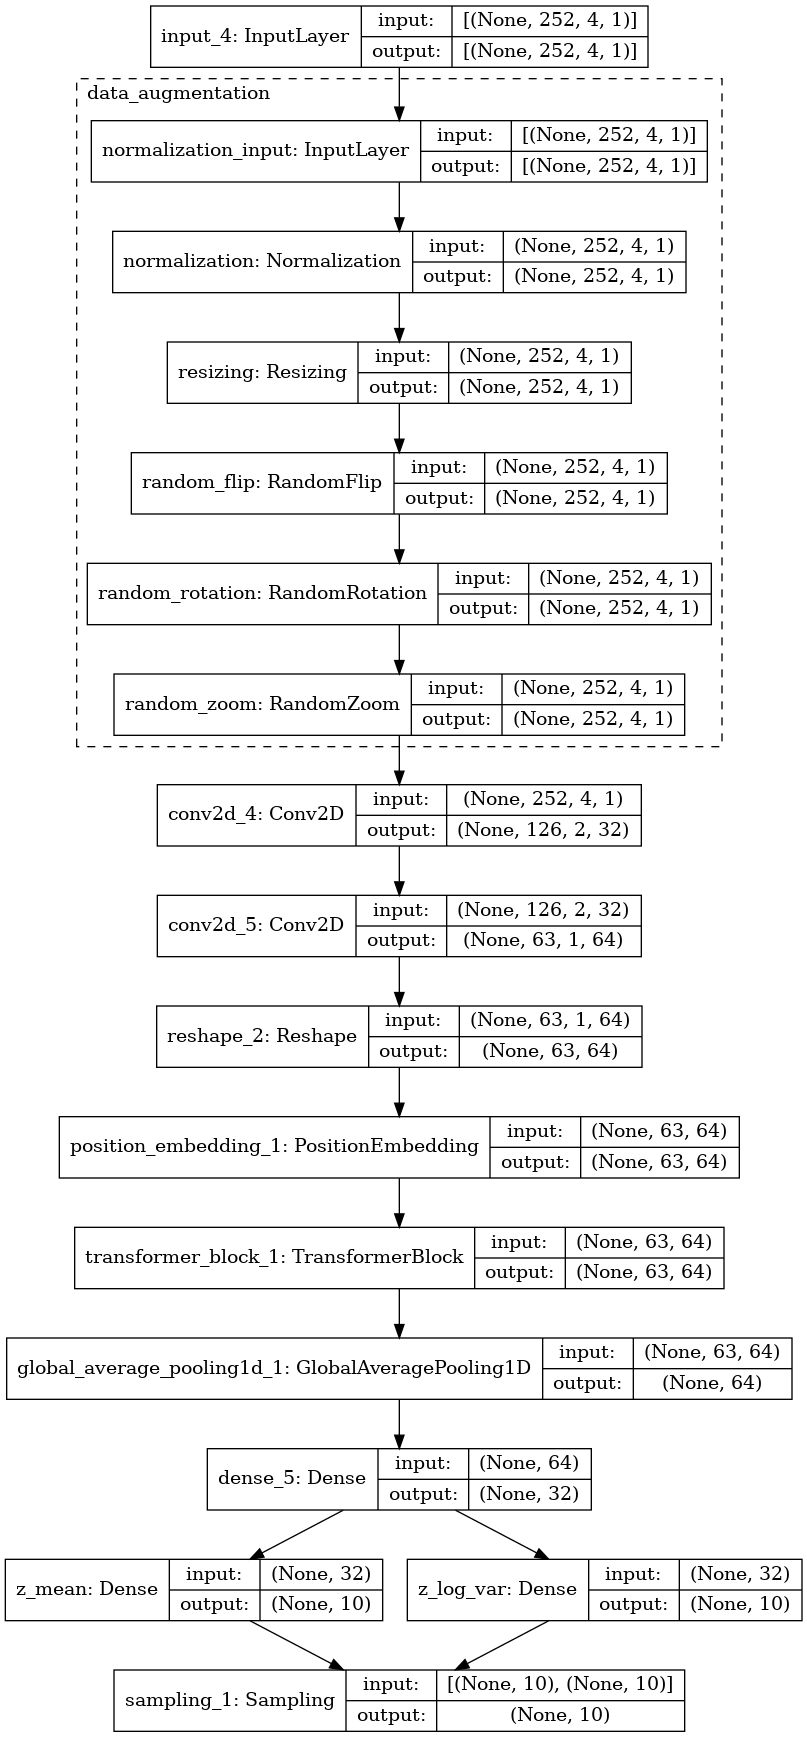

In [24]:
encoder.summary()
keras.utils.plot_model(encoder,
                       to_file="vae-mnist-encoder.png",
                       show_shapes=True,
                       expand_nested=True)

In [30]:
with strategy.scope():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(63 * 2 * 64, activation="relu")(latent_inputs)
    x = keras.layers.Reshape((63 * 2,embed_dim))(x)
    embedding_layer = PositionEmbedding(x.shape[-2],embed_dim)
    x = embedding_layer(x)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    # x = keras.layers.GlobalAveragePooling1D()(x)
    x = layers.Reshape((63, 2, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=(2,1), padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 8064)              88704     
_________________________________________________________________
reshape_9 (Reshape)          (None, 126, 64)           0         
_________________________________________________________________
position_embedding_5 (Positi (None, 126, 64)           8064      
_________________________________________________________________
transformer_block_5 (Transfo (None, 126, 64)           149504    
_________________________________________________________________
reshape_10 (Reshape)         (None, 63, 2, 64)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 126, 4, 64)        3692

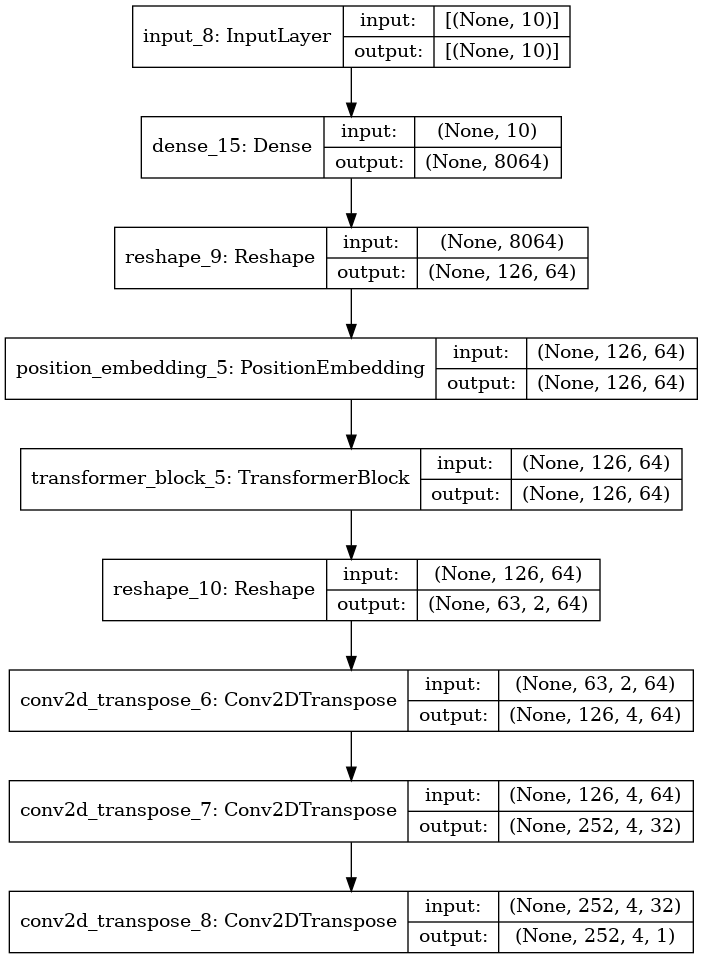

In [31]:
decoder.summary()
keras.utils.plot_model(decoder,
                       to_file="vae-mnist-decoder.png",
                       show_shapes=True,
                       expand_nested=True)

In [32]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

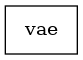

In [33]:
with strategy.scope():
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Nadam())
keras.utils.plot_model(vae,to_file='transvit-mnist.png',show_shapes=True,expand_nested=True)

In [34]:
with strategy.scope():
    vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
495/495 [==============================] - 214s 427ms/step - loss: 307.9309 - reconstruction_loss: 269.1682 - kl_loss: 3.2499
Epoch 2/30
495/495 [==============================] - 215s 434ms/step - loss: 259.0994 - reconstruction_loss: 257.4896 - kl_loss: 1.6006
Epoch 3/30
495/495 [==============================] - 216s 436ms/step - loss: 259.4770 - reconstruction_loss: 257.1539 - kl_loss: 1.3740
Epoch 4/30
347/495 [====================>.........] - ETA: 1:04 - loss: 257.9922 - reconstruction_loss: 256.6806 - kl_loss: 1.3083

KeyboardInterrupt: 